In [1]:
import sqlite3
from sqlite3 import Error
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_predict, GridSearchCV, cross_val_score 
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics

In [2]:
def setpvalue(series):
    return (series<0.01).replace({True:'*',False:''}) + (series<0.05).replace({True:'*',False:''}) + (series<0.1).replace({True:'*',False:''})

In [4]:
raw = pd.read_csv('dataset'+str(1040)+'.csv') 

In [5]:
raw.columns[7:15]

Index(['c_birthyear', 'c_deathyear', 'c_death_age', 'c_fl_earliest_year',
       'c_fl_ey_nh_code', 'c_fl_latest_year', 'Longitude', 'Latitude'],
      dtype='object')

In [8]:
pd.concat([raw.iloc[:,7],raw.iloc[:,9:11], raw.iloc[:,12:-4],raw.iloc[:,-2:-1]], axis = 1)

,c_birthyear,c_death_age,c_fl_earliest_year,c_fl_latest_year,Longitude,Latitude,Lu_0,Lu_11026,Lu_11027,Lu_11141,...,entry_161,entry_163,entry_165,entry_166,entry_168,entry_169,entry_225,entry_226,entry_248,status
0,0,0,1074,1074,0.000000,0.000000,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
1,0,0,0,0,112.382630,34.665276,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
2,0,0,0,1043,0.000000,0.000000,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
3,0,0,0,0,116.351341,27.984781,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
4,0,0,0,0,120.578262,30.004515,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
5,998,44,0,0,114.343330,34.785477,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.000000
6,0,76,0,0,119.321577,26.073954,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
7,985,66,0,0,120.618622,31.312710,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
8,0,0,0,0,114.343330,34.785477,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.000000
9,0,0,0,0,114.856377,34.063873,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.000000


In [34]:
pd.concat([raw.iloc[:,7],raw.iloc[:,9:11], raw.iloc[:,12:-4],raw.iloc[:,-1:]], axis = 1)

,c_birthyear,c_death_age,c_fl_earliest_year,c_fl_latest_year,Longitude,Latitude,Lu_0,Lu_11026,Lu_11027,Lu_11141,...,entry_161,entry_163,entry_165,entry_166,entry_168,entry_169,entry_225,entry_226,entry_248,nemesis
0,0,0,1074,1074,0.000000,0.000000,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
1,0,0,0,0,112.382630,34.665276,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
2,0,0,0,1043,0.000000,0.000000,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
3,0,0,0,0,116.351341,27.984781,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
4,0,0,0,0,120.578262,30.004515,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
5,998,44,0,0,114.343330,34.785477,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.000000
6,0,76,0,0,119.321577,26.073954,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
7,985,66,0,0,120.618622,31.312710,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
8,0,0,0,0,114.343330,34.785477,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.000000
9,0,0,0,0,114.856377,34.063873,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.000000


# Linear Regression

In [3]:
import scipy.stats as sp # for spearman correlation
import statsmodels.api as sm
from scipy import stats # for logistic regression
from statsmodels.formula.api import ols

In [35]:
def analysis(year,spearmanflag,score):   

   
    # Read raw file
    raw = pd.read_csv('dataset'+str(year)+'.csv') 
    
    # Fill missing value: years, ages with mean
    for columnname in raw.iloc[:,7:15].columns:
        meanvalue = raw[raw[columnname] !=0][columnname].mean()
        raw[columnname] = raw[columnname].replace({0:meanvalue})
    
    
    if score =='status':        
        dataset_X = pd.concat([raw.iloc[:,7],raw.iloc[:,9:11], raw.iloc[:,12:-4],raw.iloc[:,-2:-1]], axis = 1)
    elif score =='nemesis':
        dataset_X = pd.concat([raw.iloc[:,7],raw.iloc[:,9:11], raw.iloc[:,12:-4],raw.iloc[:,-1:]], axis = 1)
    else:
        print ('wrong score code')
        return 0    
    
    
    
    dataset_y = raw.iloc[:,2]
    
    glm = sm.OLS(dataset_y, dataset_X)
    resultmodel = glm.fit()
    
    coeffandp = pd.concat([pd.DataFrame(resultmodel.params, columns = [year]),\
                           pd.DataFrame(resultmodel.pvalues, columns = ['pvalue'])] , axis  = 1)
    
    
    
    coeffandp['sx'] = np.where(coeffandp.pvalue < 0.10, '*', '')
    coeffandp['s5'] = np.where(coeffandp.pvalue < 0.05, '*', '')
    coeffandp['s1'] = np.where(coeffandp.pvalue < 0.01, '*', '')
    coeffandp[str(year)+'mk'] = coeffandp['sx'] + coeffandp['s5'] + coeffandp['s1']
    
    coeffandp.drop(['sx','s5','s1','pvalue'], inplace = True, axis =1)
    
    if (spearmanflag == 1):
        
        fulldata = pd.concat([dataset_y,dataset_X], axis = 1)

        spearmanresult = sp.spearmanr(fulldata)

        spearmandf = pd.DataFrame(spearmanresult.correlation, index = fulldata.columns)
        spearmandf.columns = fulldata.columns
        spearmandfp = pd.DataFrame(spearmanresult.pvalue, index = fulldata.columns)
        spearmandfp.columns = fulldata.columns
                                      
        return coeffandp, resultmodel, spearmandf, spearmandfp
    else:
        return coeffandp, resultmodel
                                      
                                

        
    

### R-square

In [ ]:
dflist = []

for year in range(960,1280,10):
    stats ={}
    stats['R-squared'] = modeldict[year].rsquared
    stats['Adjusted R-squared'] = modeldict[year].rsquared_adj
    stats['F-statistic'] = modeldict[year].fvalue
    stats['F-stat p-value'] = modeldict[year].f_pvalue
    
    dflist.append(pd.DataFrame(stats,index =[year]))

In [ ]:
# R-squared table

significantvariablenumber = {}
for startingyear in range(960,1280,10):
    significantvariablenumber[startingyear] = len(coefdict[startingyear][coefdict[startingyear].iloc[:,-1] != ''])
    
    
rsquare = pd.concat(dflist)
rsquare.iloc[:,-1] = setpvalue(rsquare.iloc[:,-1])
pd.concat([rsquare,pd.DataFrame(significantvariablenumber, index = ['Number of Variable found significant']).T],axis =1).to_csv('newrsquare.csv')

###  Geographic stats

In [ ]:
significantlu  ={}
for startingyear in range(960,1280,10):
    tempdf = coefdict[startingyear][6:35]
    significantlu[startingyear] = len(tempdf[tempdf.iloc[:,-1] != ''])
    print (tempdf)

In [ ]:
dflist = []
for startingyear in range(960,1280,10):
    
    convertingdict = {}

    convertingdict['Longitude'] = coefdict[startingyear].iloc[4:6].iloc[0,0]
    convertingdict['Lonp'] = coefdict[startingyear].iloc[4:6].iloc[0,1]
    convertingdict['Latitude'] = coefdict[startingyear].iloc[4:6].iloc[1,0]
    convertingdict['Ltp'] = coefdict[startingyear].iloc[4:6].iloc[1,1]

    dflist.append(pd.DataFrame(convertingdict,index = [startingyear]))
lonlatdf = pd.concat(dflist)

In [ ]:
geo = pd.concat([pd.DataFrame(significantlu, index = ['Number of Significant Lu']).T,lonlatdf],axis = 1)

In [ ]:
geo.to_csv('georesult.csv')

### Bloodline

In [ ]:
bloodroutes = ['entry_8','entry_59','entry_60','entry_62','entry_118']

In [ ]:
for startingyear in range(960,1280,10):
    print (coefdict[startingyear].T[bloodroutes])

In [ ]:
dflist = []

for startingyear in range(960,1280,10):
    tempdf = coefdict[startingyear].T[bloodroutes].T
    convertingdict ={}
    for i in range(len(bloodroutes)):
        convertingdict[bloodroutes[i]] = tempdf.iloc[i,0]
        convertingdict[bloodroutes[i]+'p'] = tempdf.iloc[i,1]

    dflist.append( pd.DataFrame(convertingdict, index = [startingyear]))

In [ ]:
pd.concat(dflist).to_csv('bloodresult.csv')

### Jinshi

In [ ]:
eliteroutes = ['entry_36','entry_165']

In [ ]:
dflist = []

for startingyear in range(960,1280,10):
    tempdf = coefdict[startingyear].T[eliteroutes].T
    convertingdict ={}
    for i in range(len(eliteroutes)):
        convertingdict[eliteroutes[i]] = tempdf.iloc[i,0]
        convertingdict[eliteroutes[i]+'p'] = tempdf.iloc[i,1]

    dflist.append( pd.DataFrame(convertingdict, index = [startingyear]))

In [ ]:
pd.concat(dflist).to_csv('eliteresult.csv')

### Network

In [70]:
coefdict = {}
modeldict = {}
spearmandict = {}

for startingyear in range(960,1280,10):

    coeffdf, model, spearmandf, spearmandfp = analysis(startingyear,1,'status')
    
    coefdict[startingyear] = coeffdf
    modeldict[startingyear] = model
    spearmandict[startingyear] = (spearmandf,spearmandfp)

NameError: name 'analysis' is not defined

In [ ]:
network = ['status'] #,'nemesis'

In [71]:
dflist = []

for startingyear in range(960,1280,10):
    tempdf = coefdict[startingyear].T[network].T
    convertingdict ={}
    for i in range(len(network)):
        convertingdict[network[i]] = tempdf.iloc[i,0]
        convertingdict[network[i]+'p'] = tempdf.iloc[i,1]

    dflist.append( pd.DataFrame(convertingdict, index = [startingyear]))

KeyError: 960

In [44]:
pd.concat(dflist).to_csv('status_only_result.csv')

# Nemesis 

In [36]:
coefdict = {}
modeldict = {}
spearmandict = {}

for startingyear in range(960,1280,10):

    coeffdf, model, spearmandf, spearmandfp = analysis(startingyear,1,'nemesis')
    
    coefdict[startingyear] = coeffdf
    modeldict[startingyear] = model
    spearmandict[startingyear] = (spearmandf,spearmandfp)

In [37]:
network = ['nemesis'] 

In [38]:
dflist = []

for startingyear in range(960,1280,10):
    tempdf = coefdict[startingyear].T[network].T
    convertingdict ={}
    for i in range(len(network)):
        convertingdict[network[i]] = tempdf.iloc[i,0]
        convertingdict[network[i]+'p'] = tempdf.iloc[i,1]

    dflist.append( pd.DataFrame(convertingdict, index = [startingyear]))

In [40]:
pd.concat(dflist).to_csv('nemesis_only_result.csv')

In [ ]:
pd.concat(dflist).to_csv('networkresult.csv')

# Random Forest

In [ ]:
conninput = sqlite3.connect("edgelist.db")

In [ ]:
def randomforestandreturn(year):
    
    # Read raw file
    raw = pd.read_csv('dataset'+str(year)+'.csv') 
    
    # Fill missing value: years, ages with mean
    for columnname in raw.iloc[:,7:15].columns:
        meanvalue = raw[raw[columnname] !=0][columnname].mean()
        raw[columnname] = raw[columnname].replace({0:meanvalue})
    
    
    dataset_X = pd.concat([raw.iloc[:,7],raw.iloc[:,9:11], raw.iloc[:,12:-4],raw.iloc[:,-2:]], axis = 1)
    dataset_y = raw.iloc[:,2]

    # Perform Grid-Search 
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,20),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

    grid_result = gsc.fit(dataset_X, dataset_y)
    best_params = grid_result.best_params_

    sel = SelectFromModel(RandomForestRegressor(max_depth=best_params["max_depth"],
                                n_estimators=best_params["n_estimators"],
                                random_state=False, verbose=False))
    sel.fit(dataset_X, dataset_y)

    rfr = RandomForestRegressor(max_depth=best_params["max_depth"],
                                n_estimators=best_params["n_estimators"],
                                random_state=False, verbose=False)
    # Perform K-Fold CV
    scores = cross_val_score(rfr, dataset_X, dataset_y, cv=10, scoring='neg_mean_absolute_error')
    predictions = cross_val_predict(rfr, dataset_X,dataset_y, cv=10)
    MSE = metrics.mean_squared_error(dataset_y, predictions)

    #    return predictions
    
    rfr.fit(dataset_X, dataset_y)
    
    return MSE, pd.DataFrame(rfr.feature_importances_, index = dataset_X.columns, columns = [year]).T

In [ ]:
connoutput =  sqlite3.connect("gini_finalR.db")

In [ ]:
msedict = {}
ginidict = {}

In [ ]:
for startingyear in range(960,1280,10):
    
    if startingyear in msedict:
        continue
    
    print('processing '+str(startingyear))
    
    mse, gini = randomforestandreturn(startingyear)

    #gini.to_sql('gini'+str(startingyear), con=connoutput, if_exists='replace')
    
    msedict[startingyear] = mse
    ginidict[startingyear] = gini

In [ ]:
msetable = pd.DataFrame(msedict, ['mse']).T
    

In [ ]:
msetable['sd'] = np.sqrt(msetable['mse'])

In [ ]:
msetable.to_csv('newmse.csv')

In [ ]:
convertingdict ={}

for startingyear in range(960,1280,10):

    convertingdict[startingyear] = ginidict[startingyear].T.sort_values(by = startingyear, ascending = False).index[0:10]


In [ ]:
pd.DataFrame(convertingdict, index = range(1,11)).T.to_csv('giniresult.csv')

In [ ]:
range(960,1280,10)

In [ ]:
pd.DataFrame(msedict, index = ['mse']).T.to_csv('mse.csv')

In [ ]:
ginis = {}
for year in range(960,1280,10):
    ginis[year]= pd.read_sql_query("SELECT * FROM gini"+str(year), 
                         sqlite3.connect('gini_finalR.db')).drop_duplicates()

In [ ]:
dflis = []
for year in range(960,1280,10):

    tempdf = ginis[year].T.sort_values(by = 0, ascending = False).iloc[1:11].reset_index()
    tempdf.columns = [str(year)+'+factor',str(year)+'+gini']
    dflis.append(tempdf)

In [ ]:
pd.concat(dflis, axis =1).to_csv('ginipresent10.csv')

In [ ]:
t2df.loc[960][0] = str(tempdf.index[0])
t2df

In [ ]:
pd.DataFrame(tempdict,index = ['960'])

### Coefficient

In [ ]:
dflist = []
for year in coefdict:
    dflist.append(coefdict[year])

In [ ]:
coeffull = pd.concat(dflist, axis = 1)

In [ ]:
coeffull.to_csv('coefficient.csv')

In [ ]:
testdf

In [ ]:
pearsondict = {}

for year in range(960,1280,10):

    raw = pd.read_csv('dataset'+str(year)+'.csv') 
    
    pearsondict[year]=stats.pearsonr(raw.iloc[:,-2],raw.iloc[:,-1])

In [ ]:
pd.DataFrame(pearsondict, index = ['corr','p-value']).T.to_csv('nemesis-status-correlation.csv')

In [ ]:
for year in range(960,1280,10):

    raw = pd.read_csv('dataset'+str(year)+'.csv') 
    
    print(raw.iloc[:,-2])
    print (raw.iloc[:,-1])

In [13]:
ginis = {}
for year in range(960,1280,10):
    ginis[year]= pd.read_sql_query("SELECT * FROM gini"+str(year), 
                         sqlite3.connect('gini_finalR.db')).drop_duplicates()

In [32]:
df = pd.DataFrame()
for i in ginis:
       
    temp =  ginis[i].drop('index', axis =1).T.copy()
    temp['date']=i
    
    df = pd.concat([df,temp], axis = 0)

In [34]:
df.to_csv('ginitransformed.csv')

In [9]:
df.to_csv('ginifull.csv')

In [35]:
datum = {}
for year in range(960,1280,10):
    datum[year]= pd.read_csv('dataset'+str(year)+'.csv').drop_duplicates()

In [40]:
stats = {}
for i in datum:
    stats[i] = len(datum[i])

In [47]:
returndf = pd.DataFrame(stats, index = ['']).T

In [56]:
pd.concat([returndf.iloc[:16,:].reset_index(drop = False),returndf.iloc[16:,:].reset_index(drop = False)],axis = 1).to_csv('samplesize.csv')

In [58]:
fulldf = pd.DataFrame()
for i in datum:
    fulldf = pd.concat([fulldf,datum[i]], axis = 0)

In [69]:
fulldf[['Rank','status','nemesis']].describe().T.to_csv('description.csv')

In [65]:
fulldf[['Rank']]

,Rank
0,5.5
1,5.0
2,1.0
3,6.0
4,6.0
5,4.5
6,6.0
7,6.0
8,3.5
9,3.0


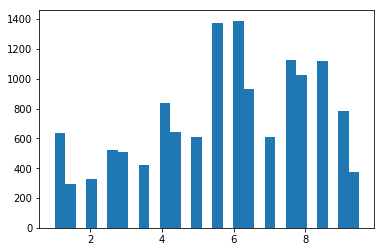

In [68]:
import matplotlib.pyplot as plt
plt.hist(fulldf['Rank'], bins='auto')
plt.show()

0      5.5
1      5.0
2      1.0
3      6.0
4      6.0
5      4.5
6      6.0
7      6.0
8      3.5
9      3.0
10     5.5
11     1.0
12     3.5
13     6.0
14     2.5
15     7.0
16     1.5
17     6.0
18     8.0
19     5.5
20     8.0
21     2.0
22     8.5
23     4.0
24     8.0
25     7.0
26     5.5
27     5.5
28     2.5
29     6.0
      ... 
197    9.0
198    3.5
199    8.5
200    9.0
201    6.0
202    4.0
203    2.5
204    4.5
205    8.0
206    5.0
207    8.5
208    1.5
209    6.0
210    3.5
211    6.5
212    5.5
213    4.5
214    6.0
215    9.0
216    6.0
217    5.5
218    9.0
219    4.0
220    9.0
221    7.5
222    4.0
223    5.5
224    7.0
225    2.0
226    9.0
Name: Rank, Length: 13527, dtype: float64